# **Fit GLM-HMM to all DMDM data with L2 regularization**
---
We next fit GLM-HMM to the all the animals in the dataset. This step is important as it searchs thorough the parameter space and find possible parameters needed to fit GLM-HMM on individual animal later. We only use outcomes `y` as a dependent variable to simplify the model here.

## **HPC setting**
Ashwood's original script is written in python scirpts. Here, we rewrite it in Jupyter to make it more user-friendly to run on HPC with `dask`. [This](https://github.com/pierreglaser/hpc-tutorial/tree/main) is very useful resource to get familiar with `dask`.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# allocate the computing resources
from dask_jobqueue import SLURMCluster
from distributed import Client
from joblib import Memory, Parallel, delayed, parallel_backend
from threadpoolctl import threadpool_limits
from tqdm import tqdm

cluster = SLURMCluster(
    workers=0,      # create the workers "lazily" (upon cluster.scal)
    memory='64g',   # amount of RAM per worker
    processes=1,    # number of execution units per worker (threads and processes)
    cores=1,        # among those execution units, number of processes
    walltime="48:00:00",
    worker_extra_args=["--resources GPU=1"], # the only way to add GPUs
    local_directory='/nfs/nhome/live/skuroda/jobs', # set your path to save log
    log_directory='/nfs/nhome/live/skuroda/jobs' # set your path to save log
)   

memory = Memory('/nfs/nhome/live/skuroda/joblib-cache') # set your path

n = 20
cluster.scale(n)
client = Client(cluster)
print(client.dashboard_link)

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:17: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/

http://192.168.234.51:8787/status


## **Fit GLM-HMM to all animals**
---

In [3]:
# ------- load modules -------
import autograd.numpy as np
import numpy as onp
import autograd.numpy.random as npr
import sys

from glm_hmm_utils import fit_glm_hmm
sys.path.append('../') # a lazy trick to search parent dir
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im
from data_io import get_file_dir, load_session_fold_lookup, load_data, load_glm_vectors
from data_labels import create_abort_mask, partition_data_by_session, partition_data_by_session_L2

from functools import partial
from collections import OrderedDict

In [4]:
# ------- setup variables -------
dname = 'dataAllHumans' # 'dataAllHumans' 'dataAllMiceTraining'
C = 3  # number of output types/categories
D = 1  # data (observations) dimension
K_vals = [1, 2, 3, 4]
ridge_lambda = [0, 100, 10000, 1000000] # for ridge regression
N_initializations = 10 #20
num_folds_training = num_folds_tuning = 5

nested_outcome = OrderedDict() # define nested structure for behavioral outcomes
nested_outcome["Baseline"] = [2]
nested_outcome["Change"] = [0, 1]

cluster_job_arr = []
for l in ridge_lambda:
    for K in K_vals:
        for i in range(num_folds_training):
             for ii in range(num_folds_tuning):
                for j in range(N_initializations):
                    cluster_job_arr.append([l, K, i, ii, j])

N_em_iters = 600  # number of EM iterations
global_fit = True
reguralization = True
paramter_tuning = True
transition_alpha = 1 # perform mle => set transition_alpha to 1
prior_sigma = 100

print('Total number of jobs: {}'.format(len(cluster_job_arr)))

Total number of jobs: 4000


In [5]:
# ------- setup path and load data -------
data_dir =  get_file_dir().parents[1] / "data" / "dmdm" / dname / 'data_for_cluster'
# Create directory for results:
try: 
    results_dir = get_file_dir().parents[1] / "results" / "dmdm_global_fit_L2" / dname
except:
    raise FileNotFoundError('Run GLM first to initialize parameters')


#  read in data and train/test split
animal_file = data_dir / 'all_animals_concat.npz'
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(animal_file)

In [6]:
def fit_GLMHMM_y(inpt_y, y, session, 
                 session_fold_lookup_table, 
                 global_fit,
                 paramter_tuning,
                 reguralization,
                 transition_alpha,
                 prior_sigma,
                 results_dir,
                 params):
    
    [l, K, fold_training, fold_tuning, iter] = params

    # Append a column of ones to inpt to represent the bias covariate:
    inpt_y = np.hstack((inpt_y, np.ones((len(inpt_y),1))))
    y = y.astype('int')
    # Identify violations for exclusion:
    abort_idx = np.where(y == 3)[0]
    nonviolation_idx, mask = create_abort_mask(abort_idx, inpt_y.shape[0])

    #  GLM weights to use to initialize GLM-HMM
    if global_fit == True:
        init_param_file = results_dir / 'GLM' / ('fold_' + str(fold_training)) / 'GLM_y_variables_of_interest_iter_0.npz'
    else:
        raise NotImplementedError('This notebook only runs global fitting')

    # Create save directory for this initialization/fold combination:
    if paramter_tuning:
        saving_directory = results_dir / ("GLM_HMM_y_K_" + str(K)) / ("fold_" + str(fold_training)) / ("tuningfold_" + str(fold_tuning)) / ('iter_' + str(iter))
    else:
        saving_directory = results_dir / ("GLM_HMM_y_K_" + str(K)) / ("fold_" + str(fold_training)) / ('iter_' + str(iter))
    saving_directory.mkdir(parents=True, exist_ok=True)

    launch_glm_hmm_job(inpt_y,
                       y,
                       session,
                       mask,
                       session_fold_lookup_table,
                       K,
                       D,
                       C,
                       N_em_iters,
                       transition_alpha,
                       prior_sigma,
                       l,
                       fold_training, 
                       fold_tuning,
                       paramter_tuning,
                       iter,
                       global_fit,
                       reguralization,
                       init_param_file,
                       saving_directory)


def launch_glm_hmm_job(inpt, y, session, mask, session_fold_lookup_table, K, D,
                       C, N_em_iters, transition_alpha, prior_sigma, l,
                       fold_training, fold_tuning, paramter_tuning, iter, global_fit, reguralization, 
                       init_param_file, save_directory):
    sys.stdout.flush()
    if paramter_tuning:
        split_loc = np.logical_and(session_fold_lookup_table[:, 1] != fold_training, session_fold_lookup_table[:, 2] != fold_tuning)
        sessions_to_keep = session_fold_lookup_table[split_loc, 0]
    else:
        sessions_to_keep = session_fold_lookup_table[np.where(
            session_fold_lookup_table[:, 1] != fold_training), 0]
        
    idx_this_fold = [str(sess) in sessions_to_keep for sess in session]
    this_inpt, this_y, this_session, this_mask = inpt[idx_this_fold, :], \
                                                 y[idx_this_fold, :], \
                                                 session[idx_this_fold], \
                                                 mask[idx_this_fold, :]
    
    # Only do this so that errors are avoided - these y values will not
    # actually be used for anything (due to violation mask)
    this_y[np.where(this_y == 3), :] = 2
    
    inputs, datas, masks = partition_data_by_session_L2(
        this_inpt, this_y, this_mask, this_session, l)
    # Read in GLM fit if global_fit = True:
    if global_fit == True:
        _, params_for_initialization = load_glm_vectors(init_param_file)
    else:
        raise NotImplementedError('This notebook only runs global fitting')
    M = this_inpt.shape[1]

    npr.seed(iter)
    fit_glm_hmm(datas,
                inputs,
                masks,
                K,
                D,
                M,
                C,
                N_em_iters,
                transition_alpha,
                prior_sigma,
                global_fit,
                reguralization,
                l,
                params_for_initialization,
                save_title=save_directory / ('GLM_HMM_y_raw_parameters_itr_' + str(iter))
                )
    
fit_GLMHMM_eachparam = partial(fit_GLMHMM_y, inpt_y, y, session, session_fold_lookup_table, 
                               global_fit, paramter_tuning, reguralization, transition_alpha, prior_sigma, results_dir)        
fit_GLMHMM_eachparam_cached = memory.cache(fit_GLMHMM_eachparam)

In [7]:
with Client(cluster) as client: # upload local functions to each worker. They cannot read them with sys.append or sys.insert.
    client.wait_for_workers(n)
    client.upload_file(str(get_file_dir() / 'data_io.py'))
    client.upload_file(str(get_file_dir() / 'data_labels.py'))

In [8]:
%%time

with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=120):
        Parallel(verbose=100)(
            delayed(fit_GLMHMM_eachparam)(params) for params in cluster_job_arr
            )

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  15 tasks      |

KeyboardInterrupt: 

In [ ]:
len(np.where(y==0)[0])

In [ ]:
def one_hot(z, K, regularize=None):
    z = np.atleast_1d(z).astype(int)
    assert np.all(z >= 0) and np.all(z < K)
    shp = z.shape
    N = z.size
    zoh = np.zeros((N, K))
    zoh[np.arange(N), np.arange(K)[np.ravel(z)]] = 1
    if regularize is not None:
        zoh_l = np.zeros((regularize, K))
        zoh = np.concatenate((zoh, zoh_l))
        zoh = np.reshape(zoh, shp + (K,))
        shp[0] = shp[0] + regularize

    else:
        zoh = np.reshape(zoh, shp + (K,))
    return zoh

In [6]:
# Once finished, shut down the cluster and the client.
try:
    memory.clear(warn=False)
except:
    pass
cluster.close()
client.close()

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon

tornado.application - ERROR - Exception in callback <bound method Cluster._sync_cluster_info of SLURMCluster(55a478a3, 'tcp://192.168.234.51:39715', workers=0, threads=0, memory=0 B)>
Traceback (most recent call last):
  File "/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/distributed/comm/core.py", line 286, in connect
    timeout=min(intermediate_cap, time_left()),
  File "/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/asyncio/tasks.py", line 449, in wait_for
    raise futures.TimeoutError()
concurrent.futures._base.TimeoutError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/tornado/ioloop.py", line 923, in _run
    await val
  File "/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/distributed/deploy/cluster.py", line 107, in _sync_cluster_info
    value=copy.copy(self._cluster_info),
  File "

## **L2 hyperparameter tuning**
---

We refit GLM-HMM again but using the best L2 hyperparam we just found.

In [8]:
from kfold_cv import KFoldCV
from data_io import load_data, load_session_fold_lookup, load_glmhmm_data, load_best_map_params, \
                     load_cv_arr, get_file_name_for_best_glmhmm_fold
from data_postprocessing_utils import calculate_state_permutation
import json

model = 'GLM_HMM_y'

In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two mi

In [ ]:
out_params = np.zeros((len(K_vals)*num_folds_training, 3), dtype='<U32') # lambda, K
idx_count = 0

for fold_training in range(num_folds_training):
    # get best lambda given fold for training

    KFCV = KFoldCV(model,num_folds_tuning, K_vals, global_fit, 
                   [transition_alpha],[prior_sigma],ridge_lambda,
                   results_dir)
    out = KFCV.save_best_L2params(inpt_y, inpt_rt, y, session, rt, stim_onset,
                                    session_fold_lookup_table, fold_training, C, 
                                    outcome_dict=nested_outcome, save_output=True)

    out_arr = np.array(out)[:,[1,0]] # sort

    out_arr_fold_animal = np.hstack([out_arr, 
                                      np.repeat(fold_training, len(K_vals)).T[:, None]])
                                    
    out_params[idx_count:idx_count+len(K_vals),:] = out_arr_fold_animal
    idx_count += len(K_vals)

np.savez(data_dir / "best_l2_params_model_{}.npz".format(model), out_params)
print("Saved all the L2 params!")
print(out_params)

In [9]:
paramter_tuning = False
fold_dummy = 100

raw_params = load_best_map_params(data_dir / "best_l2_params_model_{}.npz".format(model))
# it is okay to use load_best_map_params here as there is no difference
params = raw_params.astype('int32')

In [10]:
cluster_job_arr_2 = []
for i in range(len(params)):
        for j in range(N_initializations):
                        param_i = [params[i,0], 
                                   params[i,1],
                                   params[i,2],
                                   fold_dummy, j]
                        cluster_job_arr_2.append(param_i)

print('Total number of jobs: {}'.format(len(cluster_job_arr_2)))

Total number of jobs: 200


In [11]:
fit_GLMHMM_eachparam_2 = partial(fit_GLMHMM_y, inpt_y, y, session, session_fold_lookup_table, 
                               global_fit, paramter_tuning, reguralization, transition_alpha, prior_sigma, results_dir)        
fit_GLMHMM_eachparam_2_cached = memory.cache(fit_GLMHMM_eachparam_2)

In [12]:
with Client(cluster) as client: # upload local functions to each worker. They cannot read them with sys.append or sys.insert.
    client.wait_for_workers(n)
    client.upload_file(str(get_file_dir() / 'data_io.py'))
    client.upload_file(str(get_file_dir() / 'data_labels.py'))

In [13]:
%%time

with threadpool_limits(limits=1, user_api='blas'):
    with parallel_backend('dask', wait_for_workers_timeout=120):
        Parallel(verbose=100)(
            delayed(fit_GLMHMM_eachparam_2)(allparams) for allparams in cluster_job_arr_2
            )

[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      |

In [14]:
# Once finished, shut down the cluster and the client.
memory.clear(warn=False)
cluster.close()
client.close()

/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/dask_jobqueue/core.py:321: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gon

## **Posthoc data processing**
---

We then check the output files to find an initialization with the best log likelihood for each `K` (because EM algorithm does not gurantee that we will find the global maxima). At the same time, we look at different fold from k-fold cross-validation and calculate the normalized log likelihood. The parameters are saved for the next individual GLM-HMM fitting, and we also plot them for visualization purposes. Below is the workfrom from Ashwood et al., 2022, Nat. Neurosci..

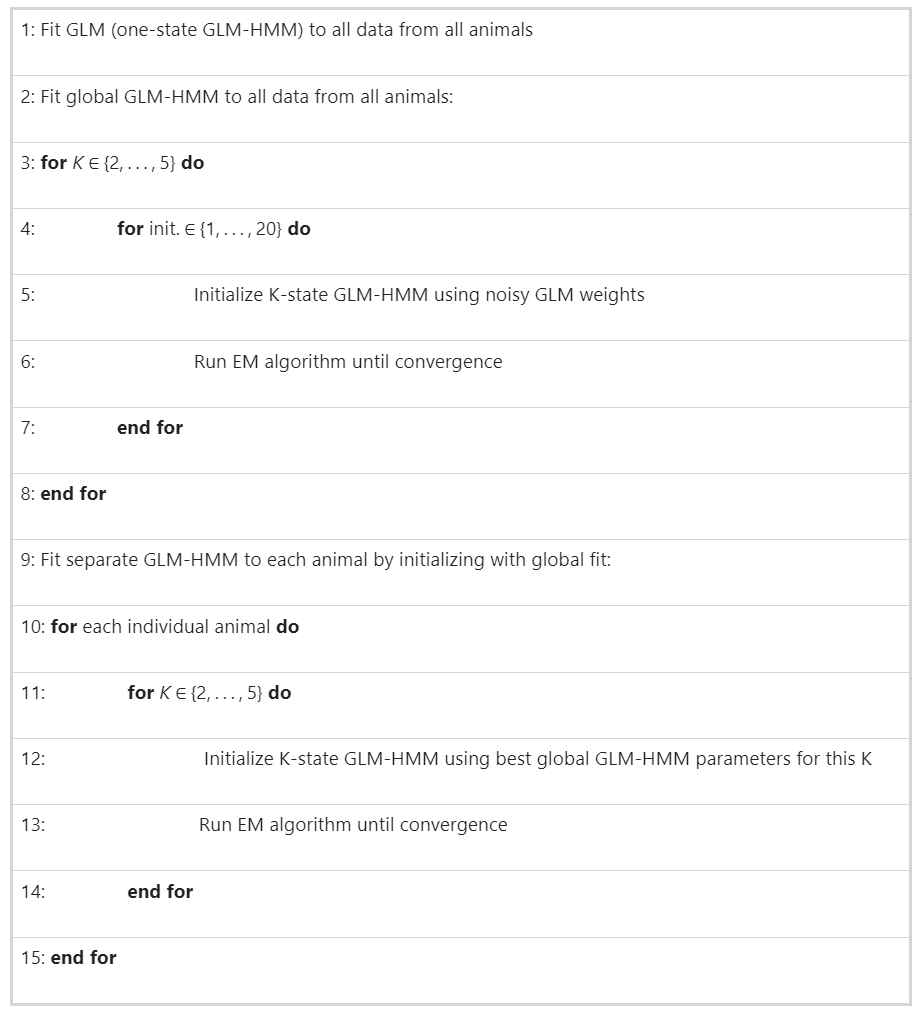

In [15]:
from kfold_cv import KFoldCV
from data_io import load_data, load_session_fold_lookup, load_glmhmm_data, load_cv_arr, get_file_name_for_best_glmhmm_fold, get_file_name_for_best_glmhmm_fold_l2, load_best_map_params
from data_postprocessing_utils import calculate_state_permutation
sys.path.append('../../../3_make_figures/dmdm/')
from plot_model_perform import plot_states, plot_model_comparison_l2
import json

model = 'GLM_HMM_y'
labels_for_plot_y = ['CSize', 'COnset', 'Outcome +1', 'Outcome +2', 'Outcome +3', 'Outcome +4', 'Outcome +5', 'bias']
saving_directory = data_dir / "best_global_params_L2"
saving_directory.mkdir(parents=True, exist_ok=True)

In [16]:
raw_params = load_best_map_params(data_dir / "best_l2_params_model_{}.npz".format(model))

inpt_y, inpt_rt, y, session, rt, stim_onset = load_data(data_dir / 'all_animals_concat.npz')
session_fold_lookup_table = load_session_fold_lookup(
    data_dir / 'all_animals_concat_session_fold_lookup.npz')

KFCV = KFoldCV(model,num_folds_training, K_vals, global_fit, 
               [transition_alpha], [prior_sigma], ridge_lambda,
               results_dir)

KFCV.save_best_iter(inpt_y, inpt_rt, y, session, rt, stim_onset,
                     session_fold_lookup_table, C, outcome_dict=nested_outcome,
                     map_params=raw_params)

Retrieving best iter results for model = GLM_HMM_y; num_folds = 5


 20%|██        | 1/5 [00:15<01:02, 15.70s/it]distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError
100%|██████████| 5/5 [01:12<00:00, 14.41s/it]

Best init saved!


In [17]:
raw_params = load_best_map_params(data_dir / "best_l2_params_model_{}.npz".format(model))

In [18]:
raw_params

array([['0', '1', '0'],
       ['1000000', '2', '0'],
       ['1000000', '3', '0'],
       ['1000000', '4', '0'],
       ['0', '1', '1'],
       ['1000000', '2', '1'],
       ['1000000', '3', '1'],
       ['1000000', '4', '1'],
       ['0', '1', '2'],
       ['1000000', '2', '2'],
       ['1000000', '3', '2'],
       ['1000000', '4', '2'],
       ['0', '1', '3'],
       ['1000000', '2', '3'],
       ['1000000', '3', '3'],
       ['1000000', '4', '3'],
       ['0', '1', '4'],
       ['1000000', '2', '4'],
       ['1000000', '3', '4'],
       ['1000000', '4', '4']], dtype='<U32')

In [20]:
cvbt_folds_model = load_cv_arr(results_dir / "cvbt_folds_model_{}.npz".format(model))
cvbt_train_folds_model = load_cv_arr(results_dir / "cvbt_train_folds_model_{}.npz".format(model))

for model_idx, K in enumerate(K_vals):
    print("K = " + str(K))
    with open(results_dir / "best_init_cvbt_dict_{}.json".format(model), 'r') as f:
        best_init_cvbt_dict = json.load(f)

    # Get the file name corresponding to the best initialization for
    # given K value
    raw_file, _ = get_file_name_for_best_glmhmm_fold_l2(
        cvbt_folds_model, model_idx, K, 0, transition_alpha, 0, prior_sigma, 
        results_dir, best_init_cvbt_dict, model,
        'GLM_HMM_y_raw_parameters_itr_', map_params=raw_params)
    hmm_params, lls, _, _, _= load_glmhmm_data(raw_file)

    # Calculate permutation
    init_state_dist, log_transition_matrix, weight_vectors, permutation = \
        calculate_state_permutation(hmm_params, K)

    if K == 1:
        best_params = weight_vectors
    elif K > 1:
        best_params = [[init_state_dist], [log_transition_matrix], weight_vectors]

    plot_states(weight_vectors,
                log_transition_matrix,
                saving_directory,
                K,
                save_title='best_params_' + model + '_K_',
                labels_for_plot=labels_for_plot_y)

    np.savez(saving_directory / ('best_params_' + model + '_K_' + str(K) + '.npz'),
             best_params)
    
plot_model_comparison_l2(cvbt_folds_model,
                      cvbt_train_folds_model,
                      global_fit,
                      K_vals,
                      saving_directory)

K = 1
K = 2


/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


K = 3


/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


K = 4


/nfs/nhome/live/skuroda/.conda/envs/glmhmm/lib/python3.7/site-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
../../../3_make_figures/dmdm/plot_model_perform.py:260: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  lw=4)
../../../3_make_figures/dmdm/plot_model_perform.py:272: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 68)` for the same effect.

  lw=4)
